# CCM counter example classification

The following example shows that CCM may not be better than STD

In [1]:
import sys
import numpy as np
from graphviz import Digraph, Source
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sympy import Matrix, simplify, symbols
from sympy.solvers.solveset import linsolve

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.flow import Graph, Node, sample_graph
from lib.data import SubColumn
from lib.models import MLP, CCM_res, SubColumnNet
from lib.train import train_step_standard, train_step_xyc, train
from lib.regularization import EYE
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap

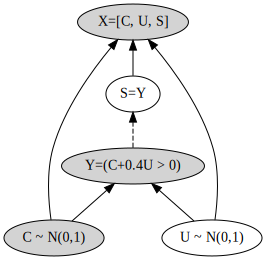

In [2]:
dot = Digraph()

dot.node('Y', 'Y=(C+0.4U > 0)', style='filled', fillcolor='lightgray')
dot.node('C', 'C ~ N(0,1)', style='filled', fillcolor='lightgray')
dot.node('U', 'U ~ N(0,1)')
dot.node('S', 'S=Y')
dot.node('X', 'X=[C, U, S]', style='filled', fillcolor='lightgray')

dot.edges(['UY', 'CY', 'UX', 'CX', 'SX'])
dot.edge('Y', 'S', style='dashed')

dot.graph_attr['rankdir'] = 'BT'
dot.render('figures/counter_example2')
dot

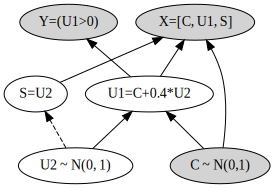

In [3]:
dot = Digraph()

dot.node('X', 'X=[C, U1, S]', style='filled', fillcolor='lightgray')
dot.node('C', 'C ~ N(0,1)', style='filled', fillcolor='lightgray')
dot.node('Y', 'Y=(U1>0)', style='filled', fillcolor='lightgray')
dot.node('U', 'U1=C+0.4*U2')
dot.node('Z', 'U2 ~ N(0, 1)')
dot.node('S', 'S=U2')
dot.edges(['UY', 'CU', 'ZU', 'UX', 'SX', 'CX'])
dot.edge('Z', 'S', style='dashed')

dot.graph_attr['rankdir'] = 'BT'
dot.render('figures/counter_example')
dot

This case is interesting b/c the problem is linear and C for sure is relevant for predicting Y.

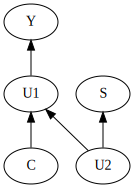

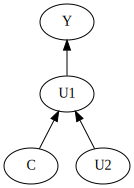

          C        U2         S        U1  Y
0 -0.182399 -0.737512 -0.737512 -0.477404  0
1  0.739294 -1.469422 -1.469422  0.151525  1
2  0.726037  0.271442  0.271442  0.834614  1
3 -1.663892 -0.377039 -0.377039 -1.814708  0
4  1.356068 -2.172212 -2.172212  0.487183  1
5 -0.679111 -0.176241 -0.176241 -0.749607  0
6 -0.073060 -0.458734 -0.458734 -0.256554  0
7 -0.245595  0.119433  0.119433 -0.197822  0
8 -0.955175  1.722368  1.722368 -0.266228  0
9 -0.178097  1.051126  1.051126  0.242353  1


,C,U2,S,U1,Y
0,-0.507981,0.769747,1.305518,-0.200082,0
1,0.282397,-1.388376,1.084935,-0.272954,0
2,1.656072,-1.084235,0.296652,1.222378,1
3,0.543222,1.231136,-0.579148,1.035677,1
4,0.165031,0.433843,-1.579649,0.338568,1
5,0.506432,0.995673,1.233886,0.904702,1
6,-0.203955,-1.393867,-0.009658,-0.761502,0
7,0.977076,-0.448235,0.209547,0.797782,1
8,1.785402,-0.866816,-1.147375,1.438676,1
9,0.826970,-1.641691,0.750169,0.170293,1


In [4]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    c = Node('C')
    u2 = Node('U2')
    s = Node('S', lambda u2: u2, [u2])
    u1 = Node('U1', lambda c, u2: c + 0.4 * u2, [c, u2])
    y  = Node('Y', lambda u1: (u1 > 0).astype(int),
              [u1], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([c, u1, u2, s, y])   
    return graph

def build_graph_deploy():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    c = Node('C')
    u2 = Node('U2')
    s = Node('S')
    u1 = Node('U1', lambda c, u2: c + 0.4 * u2, [c, u2])
    y  = Node('Y', lambda u1: (u1 > 0).astype(int),
              [u1], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([c, u1, u2, s, y])   
    return graph

graph = build_graph() # the causal graph
graph.draw()
graph_deploy = build_graph_deploy()
graph_deploy.draw()
n = 10
print(sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']])
sample_graph(graph_deploy, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]

In [5]:
np.sqrt(1.16), 1.4**2

(1.0770329614269007, 1.9599999999999997)

In [6]:
n = 100000
bs = 100
wd = 1e-4

XYC = sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
XYC_te = sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
# XYC_deploy = sample_graph(graph_deploy, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
XYC_deploy = sample_graph(graph_deploy, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U2', 'S', 'U1', 'Y']]

def get_X_Y_C(XYC):
    X = np.array(XYC[['C', 'U1', 'S']])
    Y = np.array(XYC[['Y']]).ravel()
    C = np.array(XYC[['C']])
    return torch.from_numpy(X).float(), torch.from_numpy(Y).long(), torch.from_numpy(C).float()

X, Y, C = get_X_Y_C(XYC)
d = X.shape[1]
X_te, Y_te, C_te = get_X_Y_C(XYC_te)
X_de, Y_de, C_de = get_X_Y_C(XYC_deploy)
r = torch.zeros(d) # concept mask
r[0] = 1

# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=False) # regular dataset
loader_xy_de = DataLoader(TensorDataset(X_de, Y_de), batch_size=bs, shuffle=False) # regular dataset

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 704.05it/s]


epoch   2: loss 1.482e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 826.98it/s]


epoch   5: loss 7.854e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 697.69it/s]


epoch   8: loss 5.005e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 810.29it/s]


epoch  11: loss 3.558e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 862.46it/s]


epoch  14: loss 2.798e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 869.27it/s]


epoch  17: loss 2.413e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 860.93it/s]


epoch  20: loss 2.287e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 877.15it/s]


epoch  23: loss 2.267e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 864.32it/s]


epoch  26: loss 2.254e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 889.80it/s]


epoch  29: loss 2.246e-02


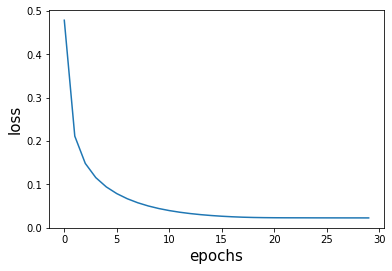

In [7]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([d, 2])
    
    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 30
STD = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [8]:
# ['C', 'U1=C+0.4*U2', 'S=U2']
STD.classifier[0].weight[1] - STD.classifier[0].weight[0]

tensor([11.4453, 16.2288,  4.6404], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 681.41it/s]


epoch   2: loss 1.392e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 651.43it/s]


epoch   5: loss 9.396e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 560.84it/s]


epoch   8: loss 8.156e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 583.69it/s]


epoch  11: loss 7.720e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 646.74it/s]


epoch  14: loss 7.334e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 693.85it/s]


epoch  17: loss 6.970e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 717.65it/s]


epoch  20: loss 6.653e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 668.27it/s]


epoch  23: loss 6.488e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 545.14it/s]


epoch  26: loss 6.409e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 609.85it/s]


epoch  29: loss 6.365e-02


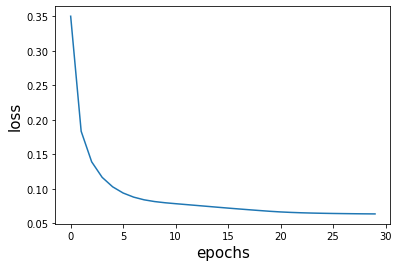

In [9]:
def CCM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([len(r), 2])

    # train
    # criterion = lambda o_y, y: F.cross_entropy(o_y, y) + 0.01 * (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum()
    criterion = lambda o_y, y: F.cross_entropy(o_y, y) + 0.0009 * EYE(r, (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum())
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=criterion)
    if plot: plot_log(log)
    return net

n_epochs = 30
ccm = CCM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [10]:
# ['C', 'U1=C+0.4*U2', 'S=U2']
ccm.classifier[0].weight[1] - ccm.classifier[0].weight[0]

tensor([ 1.5259e+01, -8.6851e-05,  5.9693e+00], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 877.64it/s]


epoch   2: loss 2.944e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 772.68it/s]


epoch   5: loss 2.680e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 643.63it/s]


epoch   8: loss 2.674e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 623.72it/s]


epoch  11: loss 2.674e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 620.30it/s]


epoch  14: loss 2.674e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 616.98it/s]


epoch  17: loss 2.674e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 610.37it/s]


epoch  20: loss 2.674e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 588.96it/s]


epoch  23: loss 2.674e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 695.35it/s]


epoch  26: loss 2.674e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 701.14it/s]


epoch  29: loss 2.674e-01


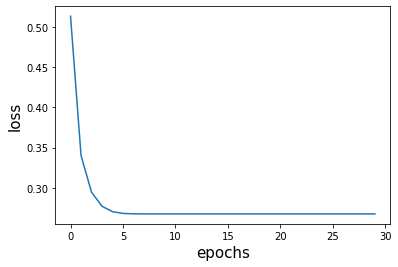

In [26]:
def CBM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = nn.Sequential(SubColumnNet(r.bool()), MLP([int(sum(r).item()), 2]))

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 30
cbm = CBM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [12]:
cbm[1].classifier[0].weight[1] - cbm[1].classifier[0].weight[0], [p for p in cbm[1].classifier.parameters()]

(tensor([2.2789], grad_fn=<SubBackward0>),
 [Parameter containing:
  tensor([[-1.4076],
          [ 0.8713]], requires_grad=True),
  Parameter containing:
  tensor([-0.4593, -0.4457], requires_grad=True)])

In [13]:
cbm[1].classifier[0].weight[1] - cbm[1].classifier[0].weight[0], [p for p in cbm[1].classifier.parameters()]

(tensor([2.2789], grad_fn=<SubBackward0>),
 [Parameter containing:
  tensor([[-1.4076],
          [ 0.8713]], requires_grad=True),
  Parameter containing:
  tensor([-0.4593, -0.4457], requires_grad=True)])

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 644.28it/s]


epoch   2: loss 6.794e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 644.08it/s]


epoch   5: loss 4.196e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 702.29it/s]


epoch   8: loss 3.106e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 630.84it/s]


epoch  11: loss 2.534e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 550.57it/s]


epoch  14: loss 2.263e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 591.71it/s]


epoch  17: loss 2.195e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 636.68it/s]


epoch  20: loss 2.178e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 566.85it/s]


epoch  23: loss 2.167e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 666.89it/s]


epoch  26: loss 2.158e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 613.80it/s]


epoch  29: loss 2.148e-02


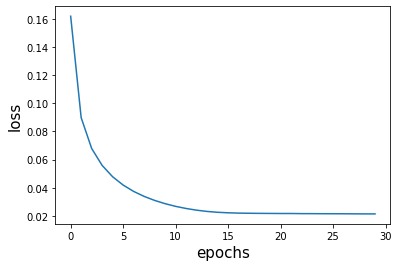

In [27]:
def Res(loader_xy, cbm, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = MLP([d, 2])    
    net = CCM_res(cbm, net)

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    # opt = optim.SGD(net.parameters(), lr=0.01, weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 30
res = Res(loader_xy, cbm, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [28]:
res.net2.classifier[0].weight[1] - res.net2.classifier[0].weight[0]

tensor([ 9.7126, 14.8247,  5.6368], grad_fn=<SubBackward0>)

In [29]:
print('task acc after training: {:.1f}%'.format(test(res, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(cbm, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy_te, acc_criterion) * 100))

test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 665.35it/s]


task acc after training: 100.0%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1088.26it/s]


task acc after training: 99.8%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1242.33it/s]


task acc after training: 87.8%


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 980.08it/s]

task acc after training: 99.9%


In [30]:
print('task acc after training: {:.1f}%'.format(test(res, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(cbm, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy_de, acc_criterion) * 100))

test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 796.16it/s]


task acc after training: 94.2%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1366.00it/s]


task acc after training: 87.8%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1335.71it/s]


task acc after training: 87.8%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1025.95it/s]

task acc after training: 95.2%


# Regression

$$min_\theta \mathbb{E}_{(x=[c,u_1,s,1], y)} (y-\theta^T x)^2$$

where $u_1 = c + a s$ with $a \in \mathbb{R}$.

taking derivative on both sides and set to $0$ simplies to 

In [18]:
# unregularized solution
c, c2, s, s2, a = symbols('E(C) E(C^2) E(S) E(S^2) a')
u1 = c + a * s
y = u1

A = Matrix([[c2, c2 + a*c*s, c*s, c], [c2 + a*c*s, c2 + a*a*s2 + 2*a*c*s, c*s + a*s2, u1], [s*c, c*s + a*s2, s2, s], [c, u1, s, 1]])
b = Matrix([[c2 + a*c*s], [c2 + a*a*s2 + 2*a*c*s], [c*s + a*s2], [y]])

result = linsolve((A, b))
result # [C, U1, S, 1]

FiniteSet((tau0/a, 1 - tau0/a, tau0, 0))

In [19]:
A

Matrix([
[              E(C^2),                 E(C)*E(S)*a + E(C^2),            E(C)*E(S),          E(C)],
[E(C)*E(S)*a + E(C^2), 2*E(C)*E(S)*a + E(C^2) + E(S^2)*a**2, E(C)*E(S) + E(S^2)*a, E(C) + E(S)*a],
[           E(C)*E(S),                 E(C)*E(S) + E(S^2)*a,               E(S^2),          E(S)],
[                E(C),                        E(C) + E(S)*a,                 E(S),             1]])

In [20]:
# unregularized CCM res solution
c, c2, s, s2, a = symbols('E(C) E(C^2) E(S) E(S^2) a')
u1 = c + a * s
y = u1

A = Matrix([[c2, c2 + a*c*s, c*s, c], [c2 + a*c*s, c2 + a*a*s2 + 2*a*c*s, c*s + a*s2, u1], [s*c, c*s + a*s2, s2, s], [c, u1, s, 1]])
b = Matrix([[a*c*s], [a*a*s2 + a*c*s], [a*s2], [a*s]])
result = linsolve((A, b))
result # [C, U1, S, 1]; CCM res solution should add back 1 to the first entry

FiniteSet((-1 + tau0/a, 1 - tau0/a, tau0, 0))

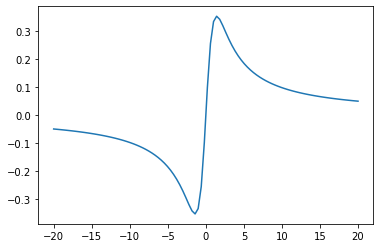

In [21]:
import matplotlib.pyplot as plt
a = np.linspace(-20, 20, 100)
plt.plot(a, 2*a / (2*a**2+4))

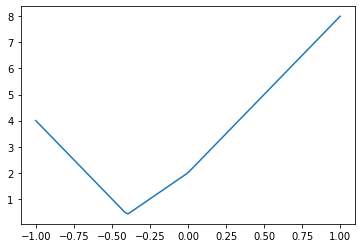

In [22]:
# l1 reg on ccm res
a = -0.4
t = np.linspace(-1, 1, 100)
plt.plot(t, np.abs(-1 + t/a) + np.abs(1-t/a) + np.abs(t))

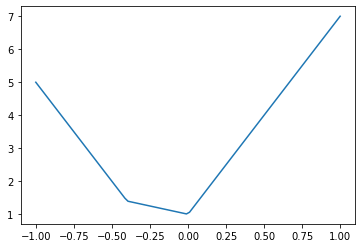

In [23]:
# l1 reg
a = -0.4
t = np.linspace(-1, 1, 100)
plt.plot(t, np.abs(t/a) + np.abs(1-t/a) + np.abs(t))

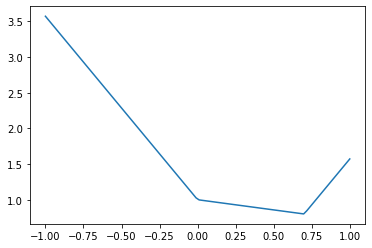

In [24]:
# weighte l1 reg
a = 0.7
b = 0.1
t = np.linspace(-1, 1, 100)
plt.plot(t, b * np.abs(t/a) + np.abs(1-t/a) + np.abs(t))

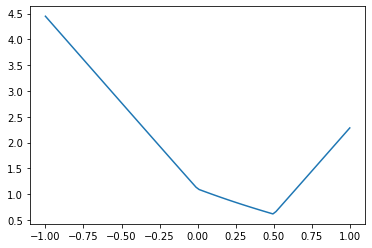

In [25]:
# EYE
a = 0.5
b = 0.1
t = np.linspace(-1, 1, 100)
plt.plot(t, b * np.sqrt((t/a)**2 + (np.abs(1-t/a) + np.abs(t))**2) + np.abs(1-t/a) + np.abs(t))